### Description

The goal of this problem was to use a CNN to classify each image as either containing metastatic tissue or not. Our data comes in the form of .tif images while the training files show image_id's with their associated labels (1: DOES contain metatstatic tissue, 0: Does NOT contain metastatic tissue). Each image is 96x96 pixels with RGB components making it (96,96,3)




In [66]:
import pandas as pd
from keras import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt

In [33]:
# Extract labels from csv training data
train_labels = pd.read_csv('histopathologic-cancer-detection/train_labels.csv')
train_labels

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0
...,...,...
220020,53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6,0
220021,d4b854fe38b07fe2831ad73892b3cec877689576,1
220022,3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75,0
220023,f129691c13433f66e1e0671ff1fe80944816f5a2,0


### Preliminary Analysis

First I would like to look at the breakdown of training data to see if we have a roughly balanced training set or if there is a skew in the outcomes of the training samples.

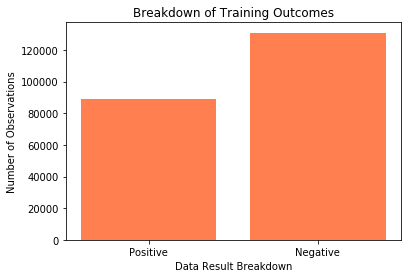

In [34]:
posCount = train_labels[train_labels['label'] == 1].shape[0]
negCount = train_labels[train_labels['label'] == 0].shape[0]


pos = train_labels[train_labels['label'] == 1]
neg = train_labels[train_labels['label'] == 0]


x = ['Positive', 'Negative']
x_pos = [0,1]

plt.bar(x_pos, [posCount,negCount], color='coral')
plt.xlabel("Data Result Breakdown")
plt.ylabel("Number of Observations")
plt.title("Breakdown of Training Outcomes")
plt.xticks(x_pos, x)
plt.show()

The bar chart above shows that we do have more negative training data points than positive so this is something to keep in mind as we review our results.

## Image Inspection

Next I would like to see the images that we will be reading in. I will figure out the size of the images as well as get a feel for what they look like and the features we will be trying to extract.

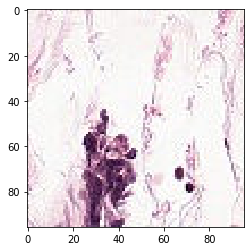

In [35]:
img = plt.imread('histopathologic-cancer-detection/train/'+pos.iloc[0]['id']+'.tif')
plt.imshow(img)

(96, 96, 3)


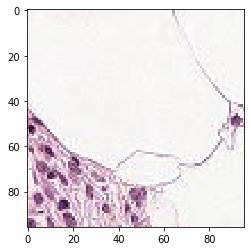

In [84]:
img = plt.imread('histopathologic-cancer-detection/train/'+neg.iloc[0]['id']+'.tif')
plt.imshow(img)
print(img.shape)

# Model Building Explanation

Now I come to the part of the exercise where I will build my model. Being that we are in the convolutional neural network unit, it seemed only right to use a CNN for this task. I becan with the pattern of $[Convolution - Convolution - MaxPool]_n$ as stated in the lecture slides that is recommended for this type of image analysis. We need the convolution layers to be able to extract the notable features of the image, and thus we repeat this pattern 4 times.

I chose padding to be 'same' because that means that there will be padding added to the edge of the picture so that the size of the image does not shrink after we apply the filter to it. As far as the kernel size, I somewhat arbitrarily chose 3 but this was also based on an example that we did in the lecture slides that suggested a 3x3 kernel would work. I had read that the number of filters should be larger on each subequent layer so I doubled the amount of filters for each set of convolutions. 

I use the Dropout as a way to reduce overfitting. We take some random weights and set them to be zero so that we end up regularizing out neural net.

Per the suggested architecture from the lecture slides, I used ReLU as the activation function for the hidden layers and sigmoid as the activation function for the output layer because the nature of our output is binary. I also chose to use RMSprop as the optimizer.

Finally, after our convolution layers, I use Flatten() to flatten the output into one long vector which is then input into a standard neural net which uses 2 dense hidden layers. 

In [87]:
# Inspiration was taken from the Kaggle notebook titled, "CNN with Keras SGD" as there was relevant information on model building and loading in data
config = [Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', input_shape = (96,96,3)),
          Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'),
          Dropout(0.3),
          MaxPooling2D(pool_size= 3),
          
          Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
          Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
          Dropout(0.3),
          MaxPooling2D(pool_size= 3),
          
          Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
          Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
          Dropout(0.3),
          MaxPooling2D(pool_size= 3),
          
          Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),
          Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),
          Dropout(0.3),
          
          Flatten(),
          Dense(128, activation='relu'),
          Dropout(0.3),
          Dense(1, activation='sigmoid')]

model = Sequential(config)
opt = RMSprop(learning_rate=0.001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 96, 96, 16)        448       
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 96, 96, 16)        2320      
_________________________________________________________________
dropout_25 (Dropout)         (None, 96, 96, 16)        0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 32, 32, 32)        4640      
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
dropout_26 (Dropout)         (None, 32, 32, 32)       

## Loading in Data

In [27]:
train_x = []
print('Num of training images: ',train_labels.shape[0])
for idx in range(train_labels.shape[0]):
    img = plt.imread('histopathologic-cancer-detection/train/'+train_labels.iloc[idx]['id']+'.tif')
    train_x.append(img)
train_subset = train_x[:100000]
label_subset = train_labels[:100000]

Num of training images:  220025


## Training CNN on Training Images

In [39]:
train_subset = np.array(train_subset)
print(len(train_labels['label']))
model.fit(x=train_subset, y=label_subset['label'], epochs=10, batch_size=64, verbose=1)

220025
Epoch 1/10
1563/1563 [==============================] - 547s 350ms/step - loss: 0.4871 - accuracy: 0.7797
Epoch 2/10
1563/1563 [==============================] - 540s 346ms/step - loss: 0.4808 - accuracy: 0.7914
Epoch 3/10
1563/1563 [==============================] - 587s 376ms/step - loss: 0.4637 - accuracy: 0.7996
Epoch 4/10
1563/1563 [==============================] - 554s 355ms/step - loss: 0.4539 - accuracy: 0.8048
Epoch 5/10
1563/1563 [==============================] - 564s 361ms/step - loss: 0.4871 - accuracy: 0.8103
Epoch 6/10
1563/1563 [==============================] - 579s 370ms/step - loss: 0.5381 - accuracy: 0.8121
Epoch 7/10
1563/1563 [==============================] - 550s 352ms/step - loss: 0.9122 - accuracy: 0.8206
Epoch 8/10
1563/1563 [==============================] - 552s 353ms/step - loss: 0.7474 - accuracy: 0.8182
Epoch 9/10
1563/1563 [==============================] - 557s 356ms/step - loss: 1.7956 - accuracy: 0.7856
Epoch 10/10
1563/1563 [================

## Loading in Testing Data

In [71]:
from glob import glob
test_ims = []
submission = pd.DataFrame()
submission = pd.DataFrame({'path': glob('histopathologic-cancer-detection/test/*.tif')})
ids = []

for img_path in list(glob('histopathologic-cancer-detection/test/*.tif')):
    ids.append(img_path.split('/')[2].split('.')[0])
    test_ims.append(plt.imread(img_path))

submission['id'] = ids
test_ims = np.array(test_ims)
print(test_ims.shape)

[[[[160  98 161]
   [184 102 176]
   [198  98 184]
   ...
   [193 132 202]
   [201 139 214]
   [103  39 117]]

  [[154 102 168]
   [181 109 183]
   [190 102 188]
   ...
   [225 163 230]
   [193 130 201]
   [218 155 226]]

  [[150 104 176]
   [157  99 176]
   [126  56 142]
   ...
   [217 153 214]
   [201 136 200]
   [168 103 169]]

  ...

  [[196 110 185]
   [215 132 204]
   [223 146 216]
   ...
   [204 135 198]
   [146  87 143]
   [238 185 237]]

  [[230 153 223]
   [206 133 202]
   [180 114 178]
   ...
   [192 112 181]
   [190 120 180]
   [208 143 199]]

  [[194 123 191]
   [197 128 195]
   [162 102 164]
   ...
   [174  87 158]
   [198 118 181]
   [200 125 184]]]


 [[[222 188 225]
   [225 195 229]
   [226 201 231]
   ...
   [231 228 235]
   [234 231 240]
   [234 231 240]]

  [[232 178 227]
   [219 167 213]
   [214 167 211]
   ...
   [238 233 240]
   [233 225 236]
   [227 219 230]]

  [[252 180 243]
   [237 166 226]
   [241 172 229]
   ...
   [237 221 234]
   [235 219 232]
   [231 213

## Predicting on Testing Images

In [75]:
print(len(test_ims))
preds = []
for idx in range(len(test_ims)):
    
    if idx % 1000 == 0:
        print(idx)
        
    preds.append( model.predict(np.expand_dims(test_ims[idx]/255.0,axis=0))[0][0] )

57458
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000


In [85]:
submission['label'] = preds
submission

,path,id,labels,label
0,histopathologic-cancer-detection/test/fd0a060e...,fd0a060ef9c30c9a83f6b4bfb568db74b099154d,0.553017,0.553017
1,histopathologic-cancer-detection/test/1f9ee06f...,1f9ee06f06d329eb7902a2e03ab3835dd0484581,0.517382,0.517382
2,histopathologic-cancer-detection/test/19709bec...,19709bec800f372d0b1d085da6933dd3ef108846,0.537493,0.537493
3,histopathologic-cancer-detection/test/7a34fc34...,7a34fc34523063f13f0617f7518a0330f6187bd3,0.541234,0.541234
4,histopathologic-cancer-detection/test/93be720c...,93be720ca2b95fe2126cf2e1ed752bd759e9b0ed,0.530335,0.530335
...,...,...,...,...
57453,histopathologic-cancer-detection/test/2581931c...,2581931c6ef068f105a872f2c5500275fc678242,0.260064,0.260064
57454,histopathologic-cancer-detection/test/11b250a6...,11b250a664d09ab59fd2afbdb2f8d786763b185d,0.553156,0.553156
57455,histopathologic-cancer-detection/test/18a60309...,18a6030935ec1ef1ce486ec51bc95abb4008fbf1,0.503618,0.503618
57456,histopathologic-cancer-detection/test/f541404e...,f541404e501e23a0188c852eb37eac94053cfdc0,0.260064,0.260064


In [88]:
actual_submission = submission[['id', 'label']]
actual_submission.to_csv('submission_niquette.csv', index=False, header=True)

In [89]:
print(actual_submission)

                                             id     label
0      fd0a060ef9c30c9a83f6b4bfb568db74b099154d  0.553017
1      1f9ee06f06d329eb7902a2e03ab3835dd0484581  0.517382
2      19709bec800f372d0b1d085da6933dd3ef108846  0.537493
3      7a34fc34523063f13f0617f7518a0330f6187bd3  0.541234
4      93be720ca2b95fe2126cf2e1ed752bd759e9b0ed  0.530335
...                                         ...       ...
57453  2581931c6ef068f105a872f2c5500275fc678242  0.260064
57454  11b250a664d09ab59fd2afbdb2f8d786763b185d  0.553156
57455  18a6030935ec1ef1ce486ec51bc95abb4008fbf1  0.503618
57456  f541404e501e23a0188c852eb37eac94053cfdc0  0.260064
57457  3cb6f5e2db8ad046c946b581fa12d20df5ce2927  0.546968

[57458 rows x 2 columns]
